In [19]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 9]

filename = "./covid-19-data-nyt/excess-deaths/deaths.csv"
ed_df = pd.read_csv(filename)
ed_df.head()

,country,placename,frequency,start_date,end_date,year,month,week,deaths,expected_deaths,excess_deaths,baseline
0,Austria,NaN,weekly,2020-01-06,2020-01-12,2020,1,2.0,1702,1814.0,-112.0,2015-2019 historical data
1,Austria,NaN,weekly,2020-01-13,2020-01-19,2020,1,3.0,1797,1824.0,-27.0,2015-2019 historical data
2,Austria,NaN,weekly,2020-01-20,2020-01-26,2020,1,4.0,1778,1832.0,-54.0,2015-2019 historical data
3,Austria,NaN,weekly,2020-01-27,2020-02-02,2020,2,5.0,1947,1836.0,111.0,2015-2019 historical data
4,Austria,NaN,weekly,2020-02-03,2020-02-09,2020,2,6.0,1678,1835.0,-157.0,2015-2019 historical data


In [4]:
filename = "./covid-19-data-nyt/us.csv"
us_df = pd.read_csv(filename)
us_df.head()

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0


In [5]:
filename = "./covid-19-data-nyt/us-counties.csv"
uscnts_df = pd.read_csv(filename)
uscnts_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [21]:
filename = "./covid-19-data-nyt/us-states.csv"
usstts_df = pd.read_csv(filename)
usstts_df.set_index('date', inplace=True)
usstts_df.tail()

,state,fips,cases,deaths
date,,,,
2020-07-12,Virginia,51,70670,1966
2020-07-12,Washington,53,42181,1438
2020-07-12,West Virginia,54,4244,96
2020-07-12,Wisconsin,55,39901,828
2020-07-12,Wyoming,56,1862,21


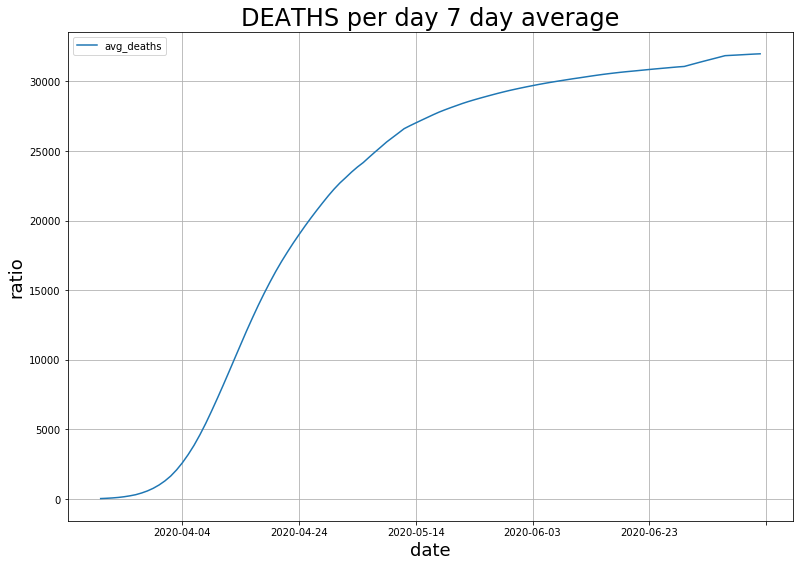

In [48]:
def stateplot(statefilter, usstts_df, param, roc=False):
    statefilt_df = usstts_df.loc[usstts_df['state'] == statefilter].copy()
    # find startpoint as first time 5 deaths occurred in one day
    startdate = statefilt_df[statefilt_df.deaths > 5].index[0]
    statefilt_df = statefilt_df.loc[startdate:]
    statefilt_df['avg_' + param] = round(statefilt_df[param].rolling(7).mean(), 1)
    if roc:
        statefilt_df[param + '_roc'] = round((statefilt_df['avg_' + param] - statefilt_df['avg_' + param].shift(1)) / statefilt_df['avg_' + param].shift(1) * 100, 1)
        newplot_df = statefilt_df[[param + '_roc']]
        ax = newplot_df.plot()
        ax.grid()
        plt.xlabel('date', fontsize=18)
        plt.ylabel('ratio', fontsize=18)
        plt.title(param.upper() + ' ROC pct per day', fontsize=24)
    else:
        newplot_df = statefilt_df[['avg_' + param]]
        ax = newplot_df.plot()
        ax.grid()
        plt.xlabel('date', fontsize=18)
        plt.ylabel('ratio', fontsize=18)
        plt.title(param.upper() + ' per day 7 day average', fontsize=24)
        
stateplot('New York', usstts_df, 'deaths', roc=False)
        

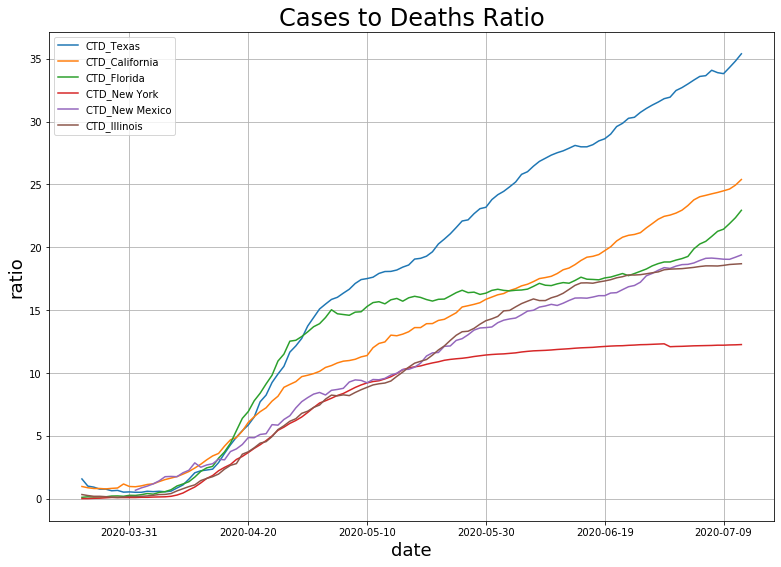

In [44]:
def ctd_ratio(fulldf, statelist, kind='line'):
    df = fulldf.copy()
    ctd_cols_list = []
    newplot_df = pd.DataFrame()
    for s in statelist:
        state_df = df.loc[df['state'] == s].copy()
        # find startpoint as first time 5 deaths occurred in one day
        startdate = df[df.deaths > 5].index[0]
        state_df = state_df.loc[startdate:]    
        state_df['cases_shift'] = state_df['cases'].shift(21)
        # CASES TO DEATH RATIO
        ctd_header = 'CTD_' + s
        state_df[ctd_header] = round(state_df['cases_shift'] / state_df['deaths'],2)
        state_df.drop(axis=1, labels=['cases_shift'], inplace=True)
        ctd_cols_list.append(ctd_header)
        if newplot_df.empty:
            newplot_df = state_df[[ctd_header]]
        else:
            newplot_df = newplot_df.merge(state_df[[ctd_header]], how='inner', left_index=True, right_index=True)

    if kind=='line':
        ax = newplot_df.plot()
        ax.grid()
        plt.xlabel('date', fontsize=18)
        plt.ylabel('ratio', fontsize=18)
        plt.title('Cases to Deaths Ratio', fontsize=24)
    elif kind=='bar':
        xpos = np.arange(len(countrylist))
        valslist = newplot_df.loc[enddate].tolist()
        plt.xticks(xpos, countrylist)
        plt.bar(xpos, valslist, align='center', width=0.6)
        plt.title('Cases to Deaths Ratio', fontsize=24)
        
statelist = ['Texas','California','Florida','New York','New Mexico','Illinois']
ctd_ratio(usstts_df, statelist)